# FINE TUNING NEW YORK

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2
import pydicom
from matplotlib.colors import cnames

# import sklearn as sk
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

from sqlalchemy import null

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [3]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, LSTM, GlobalMaxPooling2D, SeparableConv2D, BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import plot as plotly_plot

In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, hinge_loss, roc_curve, auc, precision_recall_curve

In [7]:
# Import Library.
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

In [8]:
print(f"Python {sys.version}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
TensorFlow Version: 2.10.0-dev20220413
Keras Version: 2.9.0
Pandas 1.4.3
Keras Version: 1.22.4

GPU is available


In [9]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
!nvidia-smi

Wed Dec 21 18:30:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P8    41W / 350W |   2971MiB / 12288MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import tensorflow_addons as tfa

c:\Users\Michele\anaconda3\envs\2022tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning:

You are currently using a nightly version of TensorFlow (2.10.0-dev20220413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.



In [12]:
sys.path.append('../../FUSION 2022/DATABASE_CNN/E-CNN-classifier-main/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

## STATICS

In [13]:
random_seed = 42
IMAGE_SIZE = [224,224]
CLASS_NAMES = ['MILD', 'SEVERE']

In [14]:
#PATHS FOR TRAINING

#NUOVO train w/o DS and fine tuning with DS
checkpointPath = Path('DS_training/OUTPUTS/CHECKPOINTS/')
graphPath = Path('DS_training/OUTPUTS/GRAPHS/')
pathSavedModel = Path('DS_training/OUTPUTS/MODELS-PB/')
plotpath = Path('DS_training/OUTPUTS/PLTS/')
evalpath = Path('DS_training/OUTPUTS/EVALUATIONS/')


databasePathIMAGES = Path('../COVID-19-CHEST-ONLY/manifest-1645033969298/')
tablePath = Path('DB_in_time.csv')

In [15]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
evalpath.mkdir(parents=True, exist_ok=True)

## FUNCTIONS

In [16]:
# function to find the mean value of the column
def fillWithMean(db,col_names = null):

    # print("pippo")
    if col_names == null:
        col_names = list(db.select_dtypes(exclude=['string','object','bool','datetime']).columns)

    print("numeric cols with nan values: "+str(col_names))
    for col in col_names:
        n = 0
        coln = pd.DataFrame(db[col])
        s = coln.sum().sum()
        n = len(coln)-coln.isnull().sum().sum()
        m = s/n
        db[col] = db[col].fillna(m)
    return db

# IMAGE LOADER

def clahe_transform(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
    img = clahe.apply((img * 255).astype(np.uint8)) / 255
    return img

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)


def ocr_applicaton(img, pipeline):
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
    return img

def normalize(img, min_val=None, max_val=None):
    if not min_val:
        min_val = img.min()
    if not max_val:
        max_val = img.max()
    img = (img - min_val) / (max_val - min_val)
    # img -= img.mean()
    # img /= img.std()
    return img

def load_img(img_path):
    filename, extension = os.path.splitext(img_path)
    if extension == ".dcm":
        dicom = pydicom.dcmread(img_path)
        img = dicom.pixel_array.astype(float)
        photometric_interpretation = dicom.PhotometricInterpretation
    else:
        img = Image.open(img_path)
        img = np.array(img).astype(float)
        photometric_interpretation = None
    return img, photometric_interpretation


# def loader(img_path, img_dim, mask_path=None, box=None, clahe=False):
def loader(img_path, img_dim, clahe=False, ocr_pipeline = null):
    # Img
    img, photometric_interpretation = load_img(img_path)
    min_val, max_val = img.min(), img.max()

    # Pathometric Interpretation
    if photometric_interpretation == 'MONOCHROME1':
        img = np.interp(img, (min_val, max_val), (max_val, min_val))
    # To Grayscale
    if img.ndim > 2:
        img = img.mean(axis=2)

    ## MASK AND BOX (to do?)
    # # Filter Mask
    # if mask_path:
    #     mask, _ = load_img(mask_path)
    #     img = get_mask(img, mask, value=1)

    # # Select Box Area
    # if box:
    #     img = get_box(img, box, perc_border=0.5)

    # Resize
    img = cv2.resize(img, (img_dim, img_dim))
    # Normalize
    img = normalize(img, min_val=min_val, max_val=max_val)
    # CLAHE
    if clahe:
        img = clahe_transform(img)
    
    # To 3 Channels
    img = np.stack((img, img, img), axis=-1)

    if (ocr_pipeline != null):
        img = ocr_applicaton(img,ocr_pipeline)
    
    return img

def loadAllImgToArray(DB,dimention,cName,basePt):
    paths = DB[cName].to_list()

    # apply ocr delate text
    # deletePipeline = keras_ocr.pipeline.Pipeline()
    deletePipeline = null

    # print(paths)
    imgs = []
    for p in tqdm(paths):
        img = loader(basePt / p , dimention, clahe= True, ocr_pipeline = deletePipeline)
        imgs.append(img)

    imgs = np.array(imgs)
    return imgs

## Metrics

In [17]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

def recall_m(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## DB READ

In [18]:
COVID19 = pd.read_csv(tablePath)
COVID19.head()

,Unnamed: 0.1,number_images_in_time,images_paths_in_time,images_timestamp,index,Unnamed: 0,to_patient_id,covid19_statuses,last.status,age.splits,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,FilePaths
0,0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",320.0,351.0,A000801,positive,discharged,"[18,59]",...,32.0,130.0,38.0,21.0,107.0,16.0,True,True,not documented,/SEVERE/320_A000801.png
1,1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",705.0,765.0,A000936,positive,discharged,"(59,74]",...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented,/MILD/705_A000936.png
2,2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",890.0,965.0,A001942,positive,discharged,"[18,59]",...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented,/MILD/890_A001942.png
3,3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",1098.0,1183.0,A001375,positive,discharged,"[18,59]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/MILD/1098_A001375.png
4,4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",63.0,70.0,A002052,positive,discharged,"[18,59]",...,57.0,308.0,NaN,NaN,NaN,NaN,True,False,not documented,/SEVERE/63_A002052.png


In [19]:
# print(COVID19.columns.tolist())
print(COVID19['is_icu'].value_counts())     # BEST
# print(COVID19['last.status'].value_counts())
# print(COVID19['was_ventilated'].value_counts())
# print(COVID19['pulseOx.under90'].value_counts())
# print(COVID19['covid19_statuses'].value_counts())

MILD      1022
SEVERE     257
Name: is_icu, dtype: int64


### WORK ONLY WITH IMAGES

In [20]:
COVID19 = COVID19[['number_images_in_time','images_paths_in_time','images_timestamp','to_patient_id','is_icu']]

In [21]:
COVID19.head()

,number_images_in_time,images_paths_in_time,images_timestamp,to_patient_id,is_icu
0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",A000801,SEVERE
1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A000936,MILD
2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001942,MILD
3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001375,MILD
4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",A002052,SEVERE


In [22]:
X_fullPaths = COVID19[['number_images_in_time','images_paths_in_time','images_timestamp','to_patient_id']]
Y_fullLabs = COVID19[['to_patient_id','is_icu']]

mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x

takename = copy.deepcopy(Y_fullLabs['is_icu'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
Y_fullLabs['MILD'] = one_h_enc[:,0]
Y_fullLabs['SEVERE'] = one_h_enc[:,1]

Y_fullLabs = Y_fullLabs.drop(['is_icu'], axis='columns')

C:\Users\Michele\AppData\Local\Temp\ipykernel_22444\2748737023.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Michele\AppData\Local\Temp\ipykernel_22444\2748737023.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
Y_fullLabs.head()

,to_patient_id,MILD,SEVERE
0,A000801,0.0,1.0
1,A000936,1.0,0.0
2,A001942,1.0,0.0
3,A001375,1.0,0.0
4,A002052,0.0,1.0


### Load only one image per patient

In [24]:
# save an array with all images:
X_multiple_paths = X_fullPaths

In [25]:
import re


listFirstImages = []

for pts in X_fullPaths['images_paths_in_time']:
    ps = pts.split(",")
    p = ps[-1]  #load last image
    # p = ps[0]  #load first image
    p_start = p.find("(")+2
    p_end = p.find(")")-1
    p = p[p_start:p_end]
    listFirstImages.append(p)

In [26]:
# listFirstImages[0]

In [27]:
X_fullPaths['images_paths_in_time'] = listFirstImages

C:\Users\Michele\AppData\Local\Temp\ipykernel_22444\4285604894.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
print(X_fullPaths['images_paths_in_time'][0])
# print(COVID19['images_paths_in_time'][0])

COVID-19-NY-SBU/A000801/01-20-1901-NA-CHEST AP PORT-27769/3.000000-AP-35568/1-1.dcm


## LOAD IMAGES

In [29]:
X_pt_train, X_pt_val, Y_im_train, Y_im_val = train_test_split(X_fullPaths,Y_fullLabs, test_size=0.2,shuffle=True, random_state=random_seed)

In [30]:
X_trainIMG = loadAllImgToArray(X_pt_train,IMAGE_SIZE[0],'images_paths_in_time',databasePathIMAGES)
X_valIMG = loadAllImgToArray(X_pt_val,IMAGE_SIZE[0],'images_paths_in_time',databasePathIMAGES)

100%|██████████| 256/256 [00:08<00:00, 30.24it/s]


In [31]:
print(X_trainIMG.shape)
print(X_valIMG.shape)

(1023, 224, 224, 3)
(256, 224, 224, 3)


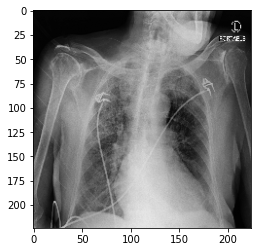

In [32]:
plt.figure()
plt.imshow(X_valIMG[2])

## MODEL LOADING

In [33]:
#dir model
HackModelpath = Path('../../FUSION 2022/DATABASE_CNN/ModelTrainedKFoldValidation/KFoldVal_11/KFoldValidation_2/')
model = tf.keras.models.load_model(HackModelpath)

### EVALUATION on NY VALIDATION of HACK model

In [34]:
# PREDICTION ON NY


evaluation = model.evaluate(x = X_valIMG, y = Y_im_val[['MILD','SEVERE']])
prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_im_val[['MILD','SEVERE']].to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalpath) + 'NY_EVALUTATION_single_image_per_patient_OF_HACKATHON_MODEL_75%.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

8/8 [==============================] - 0s 7ms/step
accuracy:  0.73828125
log_loss:  9.039548457711767
hinge_loss:  1.0859375
precision:  0.25
recall:  0.24444444444444444
[[178  33]
 [ 34  11]]
{'loss': 0.6204580664634705, 'accuracy': 0.73828125}


In [35]:
fpr, tpr, thresholds = roc_curve(yground, ypreds)
precision, recall, thresholds = precision_recall_curve(yground, ypreds)

fig = px.area(
    x=fpr, y=tpr,
    title=f'EVAL ONLY ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_ROC_CURVE_EVALUTATION_single_image_per_patient_OF_HACKATHON_MODEL_75%.html"))), auto_open=False)

fig = px.area(
    x=recall, y=precision,
    title=f'EVAL ONLY Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_Precision-Recall_CURVE_EVALUTATION_single_image_per_patient_OF_HACKATHON_MODEL_75%.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_Precision-Recall_CURVE_EVALUTATION_single_image_per_patient_OF_HACKATHON_MODEL_75%.html'

### END 2 END TRAINING on NY

#### MODEL CREATION

In [36]:
num_class = 2

In [37]:
def ResFBlock(x,filt,kernel,stride,dOutNumb,dOutParam = 0.0):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(dOutParam,name='Dropout_n_'+str(dOutNumb)+'_of_'+str(dOutParam))(x)
    return x

In [38]:
#     return lout


def MassCalcLayer_ASI(lin, num_class, blockN):
    # lin = Dropout(0.5)(lin)
    print("block n: " + str(blockN))
    weights_x = ds_layer.L1_wadd(lin.shape[1], num_class)(lin)
    weights_x = LeakyReLU()(weights_x)
    distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
    distances = LeakyReLU()(distances)
    # distances = BatchNormalization()(distances)
    # distances = BatchNormalization()(weights_x)
    # massesCalc = ds_layer.L2_masses()(distances)

    return distances

In [39]:
from unicodedata import name


def Create_CNN_ASI(inputShape = (224,224,3), outDim = 2):
    
    dropoutN = 0
    blockN = 0

    inputs = Input(shape=inputShape)

    x = ResFBlock(inputs,16,5,2,dropoutN,0.8)
    dropoutN = dropoutN+1
    block1 = ResFBlock(x,32,3,2,dropoutN,0.7)
    dropoutN = dropoutN+1
    block1 = ResFBlock(block1,32,3,1,dropoutN,0.7)
    dropoutN = dropoutN+1
    b1_pass = ResFBlock(x,32,1,2,dropoutN,0.6)
    dropoutN = dropoutN+1
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    # block1 = BatchNormalization()(block1)

    block2 = ResFBlock(block1,48,3,1,dropoutN,0.6)
    dropoutN = dropoutN+1
    block2 = ResFBlock(block2,48,3,1,dropoutN,0.6)
    dropoutN = dropoutN+1
    b2_pass = ResFBlock(block1,48,1,1,dropoutN,0.5)
    dropoutN = dropoutN+1
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    # block2 = BatchNormalization()(block2)

    block3 = ResFBlock(block2,64,3,1,dropoutN,0.5)
    dropoutN = dropoutN+1
    block3 = ResFBlock(block3,64,3,1,dropoutN,0.5)
    dropoutN = dropoutN+1
    b3_pass = ResFBlock(block2,64,1,1,dropoutN,0.3)
    dropoutN = dropoutN+1
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    # block3 = BatchNormalization()(block3)
    
    block4 = ResFBlock(block3,80,3,1,dropoutN,0.4)
    dropoutN = dropoutN+1
    block4 = ResFBlock(block4,80,3,1,dropoutN,0.4)
    dropoutN = dropoutN+1
    b4_pass = ResFBlock(block3,80,1,1,dropoutN,0.1)
    dropoutN = dropoutN+1
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    # block4 = BatchNormalization()(block4)
    
    block5 = ResFBlock(block4,96,3,1,dropoutN,0.2)
    dropoutN = dropoutN+1
    block5 = ResFBlock(block5,96,3,1,dropoutN,0.2)
    dropoutN = dropoutN+1
    b5_pass = ResFBlock(block4,96,1,1,dropoutN)
    dropoutN = dropoutN+1
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)

    # block5 = BatchNormalization()(block5)
    

    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    block1 = Flatten()(block1)
    block1 = BatchNormalization(name='block1_out')(block1)
    block1 = MassCalcLayer_ASI(block1, num_class=outDim, blockN= blockN)
    blockN = blockN + 1
    block2 = Flatten()(block2)
    block2 = BatchNormalization(name='block2_out')(block2)
    block2 = MassCalcLayer_ASI(block2, num_class=outDim, blockN= blockN)
    blockN = blockN + 1
    block3 = Flatten()(block3)
    block3 = BatchNormalization(name='block3_out')(block3)
    block3 = MassCalcLayer_ASI(block3, num_class=outDim, blockN= blockN)
    blockN = blockN + 1
    block4 = Flatten()(block4)
    block4 = BatchNormalization(name='block4_out')(block4)
    block4 = MassCalcLayer_ASI(block4, num_class=outDim, blockN= blockN)
    blockN = blockN + 1
    block5 = Flatten()(block5)
    block5 = BatchNormalization(name='block5_out')(block5)
    block5 = MassCalcLayer_ASI(block5, num_class=outDim, blockN= blockN)
    blockN = blockN + 1
    

    massFusion = Concatenate(axis=1)([block1,block2,block3,block4,block5])
    # massFusion = Add()([block1,block2,block3,block4,block5])

    massFusion = BatchNormalization()(massFusion)

    # OUTPUT WITH DS-ASI
    print("Fusione finale")
    # CALCOLO DELLE MASSE A PARTIRE DALLA LISTA DI MASSE DI OGNI LIVELLO
    print(massFusion.shape)
    weights_x = ds_layer.L1_wadd(massFusion.shape[1], outDim)(massFusion)
    weights_x = LeakyReLU()(weights_x)
    print(weights_x.shape)
    distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
    distances = LeakyReLU()(distances)
    # print(distances.shape)
    massesCalc = ds_layer.L2_masses()(distances)
    # massesCalc = ds_layer.L2_masses()(weights_x)
    print(massesCalc.shape)
    finalMasses = ds_layer.L3_combine_masses()(massesCalc)
    print(finalMasses.shape)


    print("pippo")

    # #Utility layer for testing
    # outputs = utility_layer_train.DM_pignistic(outDim)(finalMasses)
    outputs = utility_layer_train.DM_choq(finalMasses.shape[1],outDim)(finalMasses)

    print(outputs.shape)

    # OUTPUT WITHOUT DS-ASI
    # outputs = Dense(128)(massFusion)
    # outputs = LeakyReLU()(outputs)
    # outputs = BatchNormalization()(outputs)
    # outputs = Dense(64)(outputs)
    # outputs = LeakyReLU()(outputs)
    # outputs = BatchNormalization()(outputs)
    # outputs = Dense(32)(outputs)
    # outputs = LeakyReLU()(outputs)
    # outputs = BatchNormalization()(outputs)
    # outputs = Dense(8)(outputs)
    # outputs = LeakyReLU()(outputs)
    # outputs = BatchNormalization()(outputs)
    # outputs = Dense(2)(outputs)



    cnn = Model(inputs=inputs, outputs=outputs)

    return cnn

#### MODEL USE

In [40]:
model = Create_CNN_ASI((IMAGE_SIZE[0],IMAGE_SIZE[1],3), outDim=2)

block n: 0
block n: 1
block n: 2
block n: 3
block n: 4
Fusione finale
(None, 8720, 2)
(None, 8720, 2)
(None, 8720, 3)
(None, 3)
pippo
(None, 2)


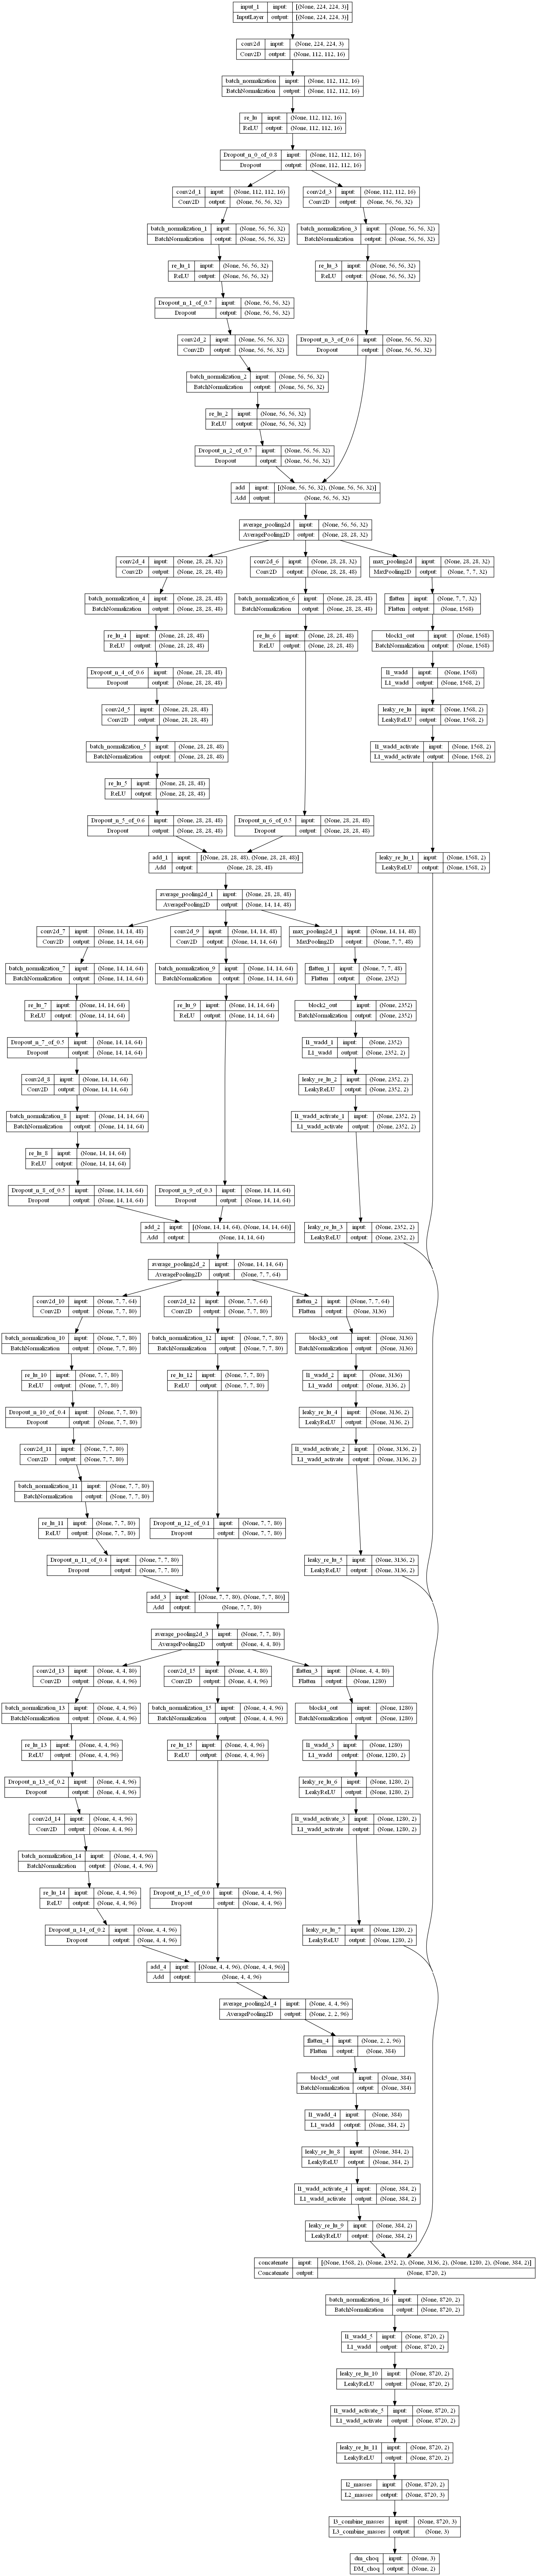

In [41]:
plot_model(model, to_file=plotpath / Path('modelloConChoquet.png'), show_shapes=True, show_layer_names=True)

In [42]:
# weights classes

mildN = Y_fullLabs['MILD'].sum()
severeN = Y_fullLabs['SEVERE'].sum()

weight_for_0 = (1 / mildN) * ((mildN+severeN) / 2.0)
weight_for_1 = (1 / severeN) * ((mildN+severeN) / 2.0)

c_w = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 MILD: {:.2f}'.format(weight_for_0))
print('Weight for class 1 SEVERE: {:.2f}'.format(weight_for_1))

Weight for class 0 MILD: 0.63
Weight for class 1 SEVERE: 2.49


In [43]:

# model = changeModelLayers(model,architectureName+'model_n_'+str(fold_var))
initial_learning_rate = 1e-3
lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate, decay_steps=300, decay_rate=0.96, staircase=False
    initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False
    # initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=False
    # initial_learning_rate, decay_steps=1000, decay_rate=0.80, staircase=False
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_sc),
    loss="binary_crossentropy",
    # loss="categorical_crossentropy",
    # loss="hinge",
    # loss=hingeLossSk,
    # metrics=['accuracy', sklearn_losses_and_metrics.SKloss, sklearn_losses_and_metrics.SKhinge, sklearn_losses_and_metrics.SKacc, sklearn_losses_and_metrics.SKprec, sklearn_losses_and_metrics.SKrec, sklearn_losses_and_metrics.SKcmat],          #metrics with sklearn
    # metrics=['accuracy', sklearn_losses_and_metrics.SKloss],          #metrics with sklearn
    # metrics=['accuracy', precision, recall, true_positives, true_negatives, false_positives, false_negatives],
    # metrics=['accuracy', precision, recall],
    # metrics=['accuracy','binary_accuracy'],
    metrics=['accuracy', f1_m, recall_m],
                )

# CREATE CALLBACKS
ck_accuracy = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('NY_END_2_END_single_image_LAST_per_patient_CHOQUET'), 
						monitor='val_f1_m', verbose=1, 
						save_best_only=True, mode='max')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)

callbacks = [ck_accuracy, early_stop]
# There can be other callbacks, but just showing one because it involves the model name
# This saves the best model
# FIT THE MODEL
history = model.fit(
            x = X_trainIMG,
            y = Y_im_train[['MILD','SEVERE']],
		    epochs=1000,
		    callbacks=callbacks,
		    validation_data=[X_valIMG,Y_im_val[['MILD','SEVERE']]],
            class_weight = c_w,            
            )




Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 7.8029 - accuracy: 0.2072 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: val_f1_m improved from -inf to 0.29388, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_END_2_END_single_image_LAST_per_patient_CHOQUET


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_END_2_END_single_image_LAST_per_patient_CHOQUET\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_END_2_END_single_image_LAST_per_patient_CHOQUET\assets


32/32 [==============================] - 10s 218ms/step - loss: 7.8029 - accuracy: 0.2072 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9730 - val_accuracy: 0.8242 - val_f1_m: 0.2939 - val_recall_m: 1.0000
Epoch 2/1000
32/32 [==============================] - ETA: 0s - loss: 7.8029 - accuracy: 0.2072 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2: val_f1_m did not improve from 0.29388
32/32 [==============================] - 1s 26ms/step - loss: 7.8029 - accuracy: 0.2072 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6405 - val_accuracy: 0.8242 - val_f1_m: 0.2939 - val_recall_m: 1.0000
Epoch 3/1000
31/32 [============================>.] - ETA: 0s - loss: 7.8380 - accuracy: 0.2097 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 3: val_f1_m did not improve from 0.29388
32/32 [==============================] - 1s 24ms/step - loss: 7.8029 - accuracy: 0.2072 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6051 - val_accuracy: 0.8242 - val_f1_m: 0.2939 - val_rec

In [44]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                  width=700,
                  title='END 2 END Loss CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_END_2_END_single_image_LAST_per_patient_training_loss_CHOQUET.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                  width=700,
                  title='END 2 END Accuracy CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_END_2_END_single_image_LAST_per_patient_training_accuracy_CHOQUET.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_m'],
                    name='Train F1'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_m'],
                    name='Validation F1'))

fig.update_layout(height=500, 
                  width=700,
                  title='END 2 END F1 CNN',
                  xaxis_title='Epoch',
                  yaxis_title='F1_param')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_END_2_END_single_image_LAST_per_patient_training_F1_CHOQUET.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_END_2_END_single_image_LAST_per_patient_training_F1_CHOQUET.html'

<Figure size 432x288 with 0 Axes>

In [45]:
bestPt = checkpointPath / Path('NY_END_2_END_single_image_LAST_per_patient_CHOQUET')
model = tf.keras.models.load_model(bestPt, custom_objects={'f1_m': f1_m, 'recall_m': recall_m})
# PREDICTION ON NY


evaluation = model.evaluate(x = X_valIMG, y = Y_im_val[['MILD','SEVERE']])
prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_im_val[['MILD','SEVERE']].to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalpath) + 'NY_END_2_END_single_image_LAST_per_patient_EVALUATION_CHOQUET.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

8/8 [==============================] - 0s 13ms/step
accuracy:  0.82421875
log_loss:  6.071269288167894
hinge_loss:  1.0
precision:  0.0
recall:  0.0
[[211   0]
 [ 45   0]]
{'loss': 1.9730076789855957, 'accuracy': 0.82421875, 'f1_m': 0.293876588344574, 'recall_m': 1.0}


c:\Users\Michele\anaconda3\envs\2022tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [46]:
fpr, tpr, thresholds = roc_curve(yground, ypreds)
precision, recall, thresholds = precision_recall_curve(yground, ypreds)

fig = px.area(
    x=fpr, y=tpr,
    title=f'END 2 END ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_ROC_CURVE_END_2_END_single_image_LAST_per_patient_EVALUATION.html"))), auto_open=False)

fig = px.area(
    x=recall, y=precision,
    title=f'END 2 END Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_Precision-Recall_CURVE_END_2_END_single_image_LAST_per_patient_EVALUATION.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_Precision-Recall_CURVE_END_2_END_single_image_LAST_per_patient_EVALUATION.html'

### FINE TUNING

In [46]:
#dir model
HackModelpath = Path('../../FUSION 2022/DATABASE_CNN/ModelTrainedKFoldValidation/KFoldVal_11/KFoldValidation_2/')
model = tf.keras.models.load_model(HackModelpath)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [48]:
numberLayers = len(model.layers)
trainableNumber = 39

# print(numberLayers)

for l in range(len(model.layers)):
    if (l>(numberLayers-trainableNumber)):
        model.layers[l].trainable = True
    else:
        model.layers[l].trainable = False


In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [50]:
# weights classes

mildN = Y_fullLabs['MILD'].sum()
severeN = Y_fullLabs['SEVERE'].sum()

weight_for_0 = (1 / mildN) * ((mildN+severeN) / 2.0)
weight_for_1 = (1 / severeN) * ((mildN+severeN) / 2.0)

c_w = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 MILD: {:.2f}'.format(weight_for_0))
print('Weight for class 1 SEVERE: {:.2f}'.format(weight_for_1))

Weight for class 0 MILD: 0.63
Weight for class 1 SEVERE: 2.49


In [51]:

# model = changeModelLayers(model,architectureName+'model_n_'+str(fold_var))
initial_learning_rate = 1e-3
lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate, decay_steps=300, decay_rate=0.96, staircase=False
    initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False
    # initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=False
    # initial_learning_rate, decay_steps=1000, decay_rate=0.80, staircase=False
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_sc),
    loss="binary_crossentropy",
    # loss="categorical_crossentropy",
    # loss="hinge",
    # loss=hingeLossSk,
    # metrics=['accuracy', sklearn_losses_and_metrics.SKloss, sklearn_losses_and_metrics.SKhinge, sklearn_losses_and_metrics.SKacc, sklearn_losses_and_metrics.SKprec, sklearn_losses_and_metrics.SKrec, sklearn_losses_and_metrics.SKcmat],          #metrics with sklearn
    # metrics=['accuracy', sklearn_losses_and_metrics.SKloss],          #metrics with sklearn
    # metrics=['accuracy', precision, recall, true_positives, true_negatives, false_positives, false_negatives],
    # metrics=['accuracy', precision, recall],
    # metrics=['accuracy','binary_accuracy'],
    metrics=['accuracy',f1_m],
                )

# CREATE CALLBACKS
ck_accuracy = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('NY_FINE_TUNING_single_image_per_patient'), 
						monitor='val_f1_m', verbose=1, 
						save_best_only=True, mode='max')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)

callbacks = [ck_accuracy, early_stop]
# There can be other callbacks, but just showing one because it involves the model name
# This saves the best model
# FIT THE MODEL
history = model.fit(
            x = X_trainIMG,
            y = Y_im_train[['MILD','SEVERE']],
		    epochs=1000,
		    callbacks=callbacks,
		    validation_data=[X_valIMG,Y_im_val[['MILD','SEVERE']]],
            class_weight = c_w,            
            )




Epoch 1/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6724 - accuracy: 0.5700 - f1_m: 0.3530
Epoch 1: val_f1_m improved from -inf to 0.22798, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 9s 235ms/step - loss: 0.6704 - accuracy: 0.5718 - f1_m: 0.3585 - val_loss: 0.6260 - val_accuracy: 0.7188 - val_f1_m: 0.2280
Epoch 2/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.6099 - f1_m: 0.3872
Epoch 2: val_f1_m improved from 0.22798 to 0.26291, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 219ms/step - loss: 0.6649 - accuracy: 0.6100 - f1_m: 0.3893 - val_loss: 0.6328 - val_accuracy: 0.7148 - val_f1_m: 0.2629
Epoch 3/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6721 - accuracy: 0.5970 - f1_m: 0.3707
Epoch 3: val_f1_m improved from 0.26291 to 0.26677, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 209ms/step - loss: 0.6677 - accuracy: 0.6012 - f1_m: 0.3680 - val_loss: 0.6415 - val_accuracy: 0.6992 - val_f1_m: 0.2668
Epoch 4/1000
32/32 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.6041 - f1_m: 0.3728
Epoch 4: val_f1_m did not improve from 0.26677
32/32 [==============================] - 1s 23ms/step - loss: 0.6668 - accuracy: 0.6041 - f1_m: 0.3728 - val_loss: 0.6448 - val_accuracy: 0.6992 - val_f1_m: 0.2668
Epoch 5/1000
32/32 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.6168 - f1_m: 0.3864
Epoch 5: val_f1_m did not improve from 0.26677
32/32 [==============================] - 0s 15ms/step - loss: 0.6624 - accuracy: 0.6168 - f1_m: 0.3864 - val_loss: 0.6495 - val_accuracy: 0.6875 - val_f1_m: 0.2613
Epoch 6/1000
30/32 [===========================>..] - ETA: 0s - loss: 0.6514 - accuracy: 0.6375 - f1_m: 0.4001
Epoch 6: val_f1_m improved from 0.26677 to 0.27513, saving model to DS_training\

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 212ms/step - loss: 0.6595 - accuracy: 0.6305 - f1_m: 0.3969 - val_loss: 0.6511 - val_accuracy: 0.6914 - val_f1_m: 0.2751
Epoch 7/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.6119 - f1_m: 0.3762
Epoch 7: val_f1_m improved from 0.27513 to 0.28303, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 216ms/step - loss: 0.6612 - accuracy: 0.6168 - f1_m: 0.3853 - val_loss: 0.6553 - val_accuracy: 0.6875 - val_f1_m: 0.2830
Epoch 8/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6501 - accuracy: 0.6379 - f1_m: 0.3925
Epoch 8: val_f1_m did not improve from 0.28303
32/32 [==============================] - 1s 21ms/step - loss: 0.6585 - accuracy: 0.6422 - f1_m: 0.4066 - val_loss: 0.6524 - val_accuracy: 0.6914 - val_f1_m: 0.2751
Epoch 9/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6542 - accuracy: 0.6293 - f1_m: 0.3949
Epoch 9: val_f1_m improved from 0.28303 to 0.28601, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 6s 209ms/step - loss: 0.6573 - accuracy: 0.6276 - f1_m: 0.3941 - val_loss: 0.6548 - val_accuracy: 0.6914 - val_f1_m: 0.2860
Epoch 10/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6631 - accuracy: 0.6361 - f1_m: 0.4066
Epoch 10: val_f1_m improved from 0.28601 to 0.30962, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 221ms/step - loss: 0.6591 - accuracy: 0.6354 - f1_m: 0.3939 - val_loss: 0.6540 - val_accuracy: 0.6992 - val_f1_m: 0.3096
Epoch 11/1000
30/32 [===========================>..] - ETA: 0s - loss: 0.6541 - accuracy: 0.6281 - f1_m: 0.3800
Epoch 11: val_f1_m did not improve from 0.30962
32/32 [==============================] - 1s 21ms/step - loss: 0.6591 - accuracy: 0.6285 - f1_m: 0.3851 - val_loss: 0.6532 - val_accuracy: 0.6992 - val_f1_m: 0.3096
Epoch 12/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6570 - accuracy: 0.6228 - f1_m: 0.3816
Epoch 12: val_f1_m did not improve from 0.30962
32/32 [==============================] - 1s 16ms/step - loss: 0.6577 - accuracy: 0.6295 - f1_m: 0.3900 - val_loss: 0.6534 - val_accuracy: 0.6953 - val_f1_m: 0.3058
Epoch 13/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6653 - accuracy: 0.6379 - f1_m: 0.4057
Epoch 13: val_f1_m did not improve from 0.30962
32/32 [====================

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 217ms/step - loss: 0.6578 - accuracy: 0.6305 - f1_m: 0.3883 - val_loss: 0.6562 - val_accuracy: 0.6992 - val_f1_m: 0.3189
Epoch 18/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6483 - accuracy: 0.6532 - f1_m: 0.4255
Epoch 18: val_f1_m improved from 0.31894 to 0.32854, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 224ms/step - loss: 0.6533 - accuracy: 0.6461 - f1_m: 0.4179 - val_loss: 0.6538 - val_accuracy: 0.7109 - val_f1_m: 0.3285
Epoch 19/1000
32/32 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.6481 - f1_m: 0.4225
Epoch 19: val_f1_m did not improve from 0.32854
32/32 [==============================] - 1s 20ms/step - loss: 0.6540 - accuracy: 0.6481 - f1_m: 0.4225 - val_loss: 0.6539 - val_accuracy: 0.7070 - val_f1_m: 0.3258
Epoch 20/1000
30/32 [===========================>..] - ETA: 0s - loss: 0.6541 - accuracy: 0.6406 - f1_m: 0.4083
Epoch 20: val_f1_m improved from 0.32854 to 0.34699, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 215ms/step - loss: 0.6560 - accuracy: 0.6393 - f1_m: 0.4031 - val_loss: 0.6548 - val_accuracy: 0.7070 - val_f1_m: 0.3470
Epoch 21/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6260 - f1_m: 0.3867
Epoch 21: val_f1_m improved from 0.34699 to 0.36801, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 219ms/step - loss: 0.6575 - accuracy: 0.6266 - f1_m: 0.3878 - val_loss: 0.6554 - val_accuracy: 0.7109 - val_f1_m: 0.3680
Epoch 22/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6250 - f1_m: 0.3949
Epoch 22: val_f1_m improved from 0.36801 to 0.38026, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 216ms/step - loss: 0.6588 - accuracy: 0.6246 - f1_m: 0.3987 - val_loss: 0.6573 - val_accuracy: 0.7148 - val_f1_m: 0.3803
Epoch 23/1000
30/32 [===========================>..] - ETA: 0s - loss: 0.6515 - accuracy: 0.6271 - f1_m: 0.3975
Epoch 23: val_f1_m did not improve from 0.38026
32/32 [==============================] - 1s 22ms/step - loss: 0.6519 - accuracy: 0.6354 - f1_m: 0.4100 - val_loss: 0.6546 - val_accuracy: 0.7109 - val_f1_m: 0.3680
Epoch 24/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6441 - accuracy: 0.6509 - f1_m: 0.4230
Epoch 24: val_f1_m did not improve from 0.38026
32/32 [==============================] - 1s 17ms/step - loss: 0.6529 - accuracy: 0.6491 - f1_m: 0.4275 - val_loss: 0.6533 - val_accuracy: 0.7188 - val_f1_m: 0.3792
Epoch 25/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6448 - accuracy: 0.6412 - f1_m: 0.4039
Epoch 25: val_f1_m did not improve from 0.38026
32/32 [====================

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 214ms/step - loss: 0.6515 - accuracy: 0.6403 - f1_m: 0.4112 - val_loss: 0.6553 - val_accuracy: 0.7188 - val_f1_m: 0.3878
Epoch 27/1000
30/32 [===========================>..] - ETA: 0s - loss: 0.6597 - accuracy: 0.6333 - f1_m: 0.4085
Epoch 27: val_f1_m did not improve from 0.38782
32/32 [==============================] - 1s 24ms/step - loss: 0.6553 - accuracy: 0.6315 - f1_m: 0.3975 - val_loss: 0.6553 - val_accuracy: 0.7188 - val_f1_m: 0.3878
Epoch 28/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6414 - accuracy: 0.6681 - f1_m: 0.4402
Epoch 28: val_f1_m did not improve from 0.38782
32/32 [==============================] - 1s 17ms/step - loss: 0.6500 - accuracy: 0.6559 - f1_m: 0.4264 - val_loss: 0.6534 - val_accuracy: 0.7188 - val_f1_m: 0.3878
Epoch 29/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6524 - accuracy: 0.6476 - f1_m: 0.4140
Epoch 29: val_f1_m did not improve from 0.38782
32/32 [====================

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 216ms/step - loss: 0.6441 - accuracy: 0.6637 - f1_m: 0.4395 - val_loss: 0.6558 - val_accuracy: 0.6836 - val_f1_m: 0.3968
Epoch 54/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6562 - f1_m: 0.4462
Epoch 54: val_f1_m did not improve from 0.39679
32/32 [==============================] - 1s 24ms/step - loss: 0.6473 - accuracy: 0.6549 - f1_m: 0.4479 - val_loss: 0.6548 - val_accuracy: 0.6797 - val_f1_m: 0.3792
Epoch 55/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6381 - accuracy: 0.6606 - f1_m: 0.4526
Epoch 55: val_f1_m did not improve from 0.39679
32/32 [==============================] - 1s 17ms/step - loss: 0.6457 - accuracy: 0.6608 - f1_m: 0.4556 - val_loss: 0.6548 - val_accuracy: 0.6797 - val_f1_m: 0.3792
Epoch 56/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6392 - accuracy: 0.6638 - f1_m: 0.4541
Epoch 56: val_f1_m did not improve from 0.39679
32/32 [====================

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 221ms/step - loss: 0.6446 - accuracy: 0.6559 - f1_m: 0.4433 - val_loss: 0.6549 - val_accuracy: 0.6875 - val_f1_m: 0.4092
Epoch 63/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6475 - accuracy: 0.6512 - f1_m: 0.4474
Epoch 63: val_f1_m improved from 0.40922 to 0.41007, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 220ms/step - loss: 0.6448 - accuracy: 0.6500 - f1_m: 0.4438 - val_loss: 0.6568 - val_accuracy: 0.6758 - val_f1_m: 0.4101
Epoch 64/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.6562 - f1_m: 0.4458
Epoch 64: val_f1_m did not improve from 0.41007
32/32 [==============================] - 1s 22ms/step - loss: 0.6440 - accuracy: 0.6569 - f1_m: 0.4475 - val_loss: 0.6550 - val_accuracy: 0.6797 - val_f1_m: 0.4032
Epoch 65/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6306 - accuracy: 0.6616 - f1_m: 0.4566
Epoch 65: val_f1_m did not improve from 0.41007
32/32 [==============================] - 0s 16ms/step - loss: 0.6424 - accuracy: 0.6618 - f1_m: 0.4621 - val_loss: 0.6532 - val_accuracy: 0.6875 - val_f1_m: 0.4092
Epoch 66/1000
32/32 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.6500 - f1_m: 0.4427
Epoch 66: val_f1_m did not improve from 0.41007
32/32 [====================

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 214ms/step - loss: 0.6442 - accuracy: 0.6657 - f1_m: 0.4636 - val_loss: 0.6573 - val_accuracy: 0.6719 - val_f1_m: 0.4157
Epoch 69/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6449 - accuracy: 0.6509 - f1_m: 0.4546
Epoch 69: val_f1_m did not improve from 0.41572
32/32 [==============================] - 1s 24ms/step - loss: 0.6452 - accuracy: 0.6452 - f1_m: 0.4455 - val_loss: 0.6567 - val_accuracy: 0.6719 - val_f1_m: 0.4157
Epoch 70/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6445 - accuracy: 0.6649 - f1_m: 0.4639
Epoch 70: val_f1_m improved from 0.41572 to 0.41704, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_FINE_TUNING_single_image_per_patient\assets


32/32 [==============================] - 7s 214ms/step - loss: 0.6431 - accuracy: 0.6628 - f1_m: 0.4598 - val_loss: 0.6562 - val_accuracy: 0.6758 - val_f1_m: 0.4170
Epoch 71/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.6462 - f1_m: 0.4410
Epoch 71: val_f1_m did not improve from 0.41704
32/32 [==============================] - 1s 22ms/step - loss: 0.6464 - accuracy: 0.6461 - f1_m: 0.4382 - val_loss: 0.6574 - val_accuracy: 0.6680 - val_f1_m: 0.4124
Epoch 72/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6492 - accuracy: 0.6498 - f1_m: 0.4478
Epoch 72: val_f1_m did not improve from 0.41704
32/32 [==============================] - 1s 16ms/step - loss: 0.6468 - accuracy: 0.6491 - f1_m: 0.4451 - val_loss: 0.6574 - val_accuracy: 0.6680 - val_f1_m: 0.4124
Epoch 73/1000
29/32 [==========================>...] - ETA: 0s - loss: 0.6409 - accuracy: 0.6595 - f1_m: 0.4471
Epoch 73: val_f1_m did not improve from 0.41704
32/32 [====================

In [52]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                  width=700,
                  title='FINE TUNING Loss CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_FINE_TUNING_single_image_per_patient_training_loss.html"))), auto_open=False)
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                  width=700,
                  title='FINE TUNING Accuracy CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_FINE_TUNING_single_image_per_patient_training_accuracy.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_FINE_TUNING_single_image_per_patient_training_accuracy.html'

<Figure size 432x288 with 0 Axes>

In [53]:
bestPt = checkpointPath / Path('NY_FINE_TUNING_single_image_per_patient')
model = tf.keras.models.load_model(bestPt, custom_objects={'f1_m': f1_m})
# PREDICTION ON NY


evaluation = model.evaluate(x = X_valIMG, y = Y_im_val[['MILD','SEVERE']])
prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_im_val[['MILD','SEVERE']].to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalpath) + 'NY_FINE_TUNING_single_image_per_patient_EVALUATION.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

8/8 [==============================] - 0s 7ms/step
accuracy:  0.67578125
log_loss:  11.198331302354845
hinge_loss:  1.1484375
precision:  0.30612244897959184
recall:  0.6666666666666666
[[143  68]
 [ 15  30]]
{'loss': 0.6561924815177917, 'accuracy': 0.67578125, 'f1_m': 0.4170397222042084}


In [54]:
fpr, tpr, thresholds = roc_curve(yground, ypreds)
precision, recall, thresholds = precision_recall_curve(yground, ypreds)

fig = px.area(
    x=fpr, y=tpr,
    title=f'FINE TUNING ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_ROC_CURVE_FINE_TUNING_single_image_per_patient_EVALUATION.html"))), auto_open=False)

fig = px.area(
    x=recall, y=precision,
    title=f'FINE TUNING Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_Precision-Recall_CURVE_FINE_TUNING_single_image_per_patient_EVALUATION.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_Precision-Recall_CURVE_FINE_TUNING_single_image_per_patient_EVALUATION.html'

# PREDICTION ON ALL IMAGES

In [55]:
# bestPt = checkpointPath / Path('NY_FINE_TUNING_single_image_per_patient')
bestPt = checkpointPath / Path('NY_END_2_END_single_image_LAST_per_patient')
model = tf.keras.models.load_model(bestPt, custom_objects={'f1_m': f1_m, 'recall_m': recall_m})

# HackModelpath = Path('../../FUSION 2022/DATABASE_CNN/ModelTrainedKFoldValidation/KFoldVal_11/KFoldValidation_2/')
# model = tf.keras.models.load_model(HackModelpath)

In [56]:
def predictionImages(NN,DB,colString,newNameColPred, dim, baseP):
    newDB = DB
    i = 0
    predPatients = []
    for patients in tqdm(DB[colString]):
        listImages = []

        ps = patients.split(",")
        # print(ps)
        for p in ps:
            # p = ps[-1]
            p_start = p.find("(")+2
            p_end = p.find(")")-1
            p = p[p_start:p_end]
            listImages.append(p)
            # print(p)
        # print(listImages)

        Imgs = []
        for imP in listImages:
            patientImg = loader(baseP / Path(imP) , dim, clahe= True)
            Imgs.append(patientImg)
        
        Imgs = np.array(Imgs)
        # print(Imgs.shape)
        predictionsPatient = NN.predict(Imgs,verbose=0)

        # print(predictionsPatient.shape)
        # break

        predPatients.append(predictionsPatient)

        i = i + 1

    newDB[newNameColPred] = predPatients
    return newDB

In [57]:
newDB = predictionImages(model,COVID19,'images_paths_in_time','predictions_per_patient',IMAGE_SIZE[0],databasePathIMAGES)

100%|██████████| 1279/1279 [08:10<00:00,  2.61it/s]


In [58]:
newDB.head()

,number_images_in_time,images_paths_in_time,images_timestamp,to_patient_id,is_icu,predictions_per_patient
0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",A000801,SEVERE,"[[0.6169692, 0.3830307], [0.7852179, 0.2147821..."
1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A000936,MILD,"[[0.7621516, 0.23784837], [0.6127402, 0.387259..."
2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001942,MILD,"[[0.80550605, 0.19449395], [0.6378237, 0.36217..."
3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001375,MILD,"[[0.6619696, 0.3380304], [0.741427, 0.258573]]"
4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",A002052,SEVERE,"[[0.28357, 0.71643], [0.46503404, 0.53496593],..."


In [59]:
newDB['predictions_per_patient'][0].shape

(34, 2)

In [60]:
newDB.to_csv('Predictions/DB_COVID_Predictions_HACK_MODEL.csv')

# FUSION OF ALL IMAGES PREDICTIONS

In [61]:
X_fullPredictions = newDB[['predictions_per_patient']]
Y_full = newDB[['to_patient_id','is_icu','number_images_in_time']]

mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x

takename = copy.deepcopy(Y_full['is_icu'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
Y_full['MILD'] = one_h_enc[:,0]
Y_full['SEVERE'] = one_h_enc[:,1]

Y_full = Y_full.drop(['is_icu'], axis='columns')

C:\Users\Michele\AppData\Local\Temp\ipykernel_10684\2204232989.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Michele\AppData\Local\Temp\ipykernel_10684\2204232989.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Model fusion predictions

In [62]:
max_number_images = int(COVID19['number_images_in_time'].max())
print(max_number_images)

136


In [85]:
from unicodedata import name


def Create_Pred_fusion_model(inputShape = (max_number_images, 2), outDim = 2):
    
    inputs = Input(shape=inputShape)

    LSTMlr = LSTM(4,unroll=True,)(inputs)

    weights_x = ds_layer.L1_wadd(LSTMlr.shape[1], outDim)(LSTMlr)
    # weights_x = ds_layer.L1_wadd(inputs.shape[1], outDim)(inputs)
    print(weights_x.shape)
    weights_x = LeakyReLU()(weights_x)
    distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
    print(distances.shape)
    distances = LeakyReLU()(distances)
    # print(distances.shape)
    massesCalc = ds_layer.L2_masses()(distances)
    # massesCalc = ds_layer.L2_masses()(weights_x)
    print(massesCalc.shape)
    finalMasses = ds_layer.L3_combine_masses()(massesCalc)
    print(finalMasses.shape)

    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(outDim)(finalMasses)

    predFusion = Model(inputs=inputs, outputs=outputs)

    return predFusion

In [86]:
fusionModel = Create_Pred_fusion_model()

(None, 4, 2)
(None, 4, 2)
(None, 4, 3)
(None, 3)


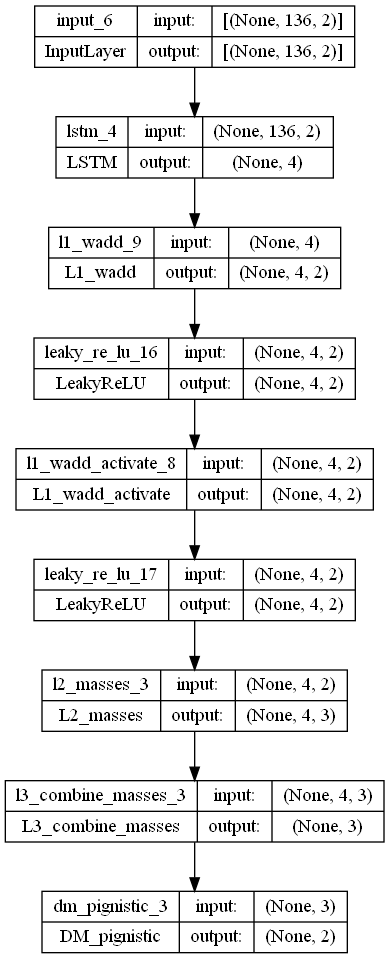

In [87]:
plot_model(fusionModel, to_file=plotpath / Path('DS_fusion_model_graph.png'), show_shapes=True, show_layer_names=True)

In [88]:
fusionModel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 136, 2)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 4)                 112       
                                                                 
 l1_wadd_9 (L1_wadd)         (None, 4, 2)              8         
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 4, 2)              0         
                                                                 
 l1_wadd_activate_8 (L1_wadd  (None, 4, 2)             8         
 _activate)                                                      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 4, 2)              0         
                                                           

## PREPROCESSING ARRAY INPUT

In [89]:
X_fullPredictions.shape[0]

1279

In [90]:
#change all elements in X_fullPredictions with shape (136,2) padding with 0
X_full_pred = []

numberImagesToTake = 0

for el in X_fullPredictions['predictions_per_patient']:
    nA = np.zeros((max_number_images,2))
    n = 0
    for e in range(len(el)):
        if numberImagesToTake < 1:
            nA[e] = el[e]
        else:
            if n < numberImagesToTake:
                nA[e] = el[e]
                n = n+1
    # print(nA.shape)
    # print(nA)
    X_full_pred.append(nA)

X_full_pred = np.array(X_full_pred)

# X_fullPredictions['predictions_per_patient'] = newArray

In [91]:
print(X_fullPredictions['predictions_per_patient'][0].shape)
print(X_full_pred[0].shape)

print("ALL IMGS")
print(X_fullPredictions['predictions_per_patient'][0])
print("Only necessary")
print(X_full_pred[0])

(34, 2)
(136, 2)
ALL IMGS
[[0.6169692  0.3830307 ]
 [0.7852179  0.21478218]
 [0.7058382  0.29416186]
 [0.5073432  0.49265683]
 [0.6583244  0.34167552]
 [0.35010022 0.6498998 ]
 [0.13331693 0.866683  ]
 [0.24377906 0.75622094]
 [0.2983557  0.7016443 ]
 [0.1744373  0.8255627 ]
 [0.30679336 0.69320667]
 [0.59169894 0.40830106]
 [0.43601102 0.563989  ]
 [0.2194484  0.78055155]
 [0.5500319  0.4499681 ]
 [0.17831771 0.8216823 ]
 [0.22984518 0.77015483]
 [0.2044256  0.7955744 ]
 [0.41711494 0.582885  ]
 [0.26740456 0.73259544]
 [0.12038348 0.8796165 ]
 [0.32663348 0.6733665 ]
 [0.21680248 0.7831975 ]
 [0.46840703 0.53159297]
 [0.167688   0.832312  ]
 [0.63374573 0.36625427]
 [0.18137644 0.81862354]
 [0.41043678 0.58956325]
 [0.2157771  0.78422284]
 [0.5649125  0.4350876 ]
 [0.5931997  0.40680033]
 [0.16419286 0.83580714]
 [0.3452044  0.6547956 ]
 [0.20026499 0.799735  ]]
Only necessary
[[0.61696923 0.38303071]
 [0.78521788 0.21478218]
 [0.7058382  0.29416186]
 [0.50734317 0.49265683]
 [0.6583

In [92]:
# Y_full = Y_full.drop('index')

In [93]:
X_pred_train, X_pred_val, Y_train, Y_val = train_test_split(X_full_pred,Y_full, test_size=0.2,shuffle=True, random_state=random_seed)

Y_train = Y_train.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)

In [94]:
print(X_pred_train)

[[[0.52187395 0.47812608]
  [0.31921166 0.68078846]
  [0.27681607 0.72318393]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.79700255 0.20299745]
  [0.65157574 0.34842426]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.73252511 0.26747492]
  [0.63910425 0.36089578]
  [0.35549483 0.64450526]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 ...

 [[0.71211433 0.28788567]
  [0.54418606 0.45581388]
  [0.56981653 0.43018347]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.71738684 0.28261316]
  [0.71236897 0.28763106]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.70255303 0.297447  ]
  [0.58269364 0.4173063 ]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]]


## TRAINING

In [95]:
# weights classes

mildN = Y_full['MILD'].sum()
severeN = Y_full['SEVERE'].sum()

weight_for_0 = (1 / mildN) * ((mildN+severeN) / 2.0)
weight_for_1 = (1 / severeN) * ((mildN+severeN) / 2.0)

c_w = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 MILD: {:.2f}'.format(weight_for_0))
print('Weight for class 1 SEVERE: {:.2f}'.format(weight_for_1))

Weight for class 0 MILD: 0.63
Weight for class 1 SEVERE: 2.49


In [96]:

# model = changeModelLayers(model,architectureName+'model_n_'+str(fold_var))
initial_learning_rate = 1e-3
lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate, decay_steps=300, decay_rate=0.96, staircase=False
    initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False
    # initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=False
    # initial_learning_rate, decay_steps=1000, decay_rate=0.80, staircase=False
)

fusionModel.compile(
    optimizer = tf.keras.optimizers.Adam(lr_sc),
    loss="binary_crossentropy",
    # loss="categorical_crossentropy",
    # loss="hinge",
    # loss=hingeLossSk,
    # metrics=['accuracy', sklearn_losses_and_metrics.SKloss, sklearn_losses_and_metrics.SKhinge, sklearn_losses_and_metrics.SKacc, sklearn_losses_and_metrics.SKprec, sklearn_losses_and_metrics.SKrec, sklearn_losses_and_metrics.SKcmat],          #metrics with sklearn
    # metrics=['accuracy', sklearn_losses_and_metrics.SKloss],          #metrics with sklearn
    # metrics=['accuracy', precision, recall, true_positives, true_negatives, false_positives, false_negatives],
    # metrics=['accuracy', precision, recall],
    # metrics=['accuracy','binary_accuracy'],
    metrics=['accuracy',f1_m],
    # metrics=['accuracy'],
                )

# CREATE CALLBACKS
ck_accuracy = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('NY_TIME_TRAINING_ALL_IMAGES_ACCURACY'), 
						monitor='val_accuracy', verbose=1, 
						save_best_only=True, mode='max')
ck_f1 = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('NY_TIME_TRAINING_ALL_IMAGES_F1'), 
						monitor='val_f1_m', verbose=1, 
						save_best_only=True, mode='max')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)

# callbacks = [ck_accuracy, early_stop]
callbacks = [ck_accuracy, ck_f1, early_stop]
# There can be other callbacks, but just showing one because it involves the model name
# This saves the best model
# FIT THE MODEL
history = fusionModel.fit(
            x = X_pred_train,
            y = Y_train[['MILD','SEVERE']],
		    epochs=1000,
		    callbacks=callbacks,
		    validation_data=[X_pred_val,Y_val[['MILD','SEVERE']]],
            class_weight = c_w,            
            )




Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7928 - f1_m: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.82422, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 1: val_f1_m improved from -inf to 0.00000, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 22s 453ms/step - loss: 0.7017 - accuracy: 0.7928 - f1_m: 0.0000e+00 - val_loss: 0.6873 - val_accuracy: 0.8242 - val_f1_m: 0.0000e+00
Epoch 2/1000
32/32 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.7928 - f1_m: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.82422

Epoch 2: val_f1_m did not improve from 0.00000
32/32 [==============================] - 2s 69ms/step - loss: 0.7015 - accuracy: 0.7928 - f1_m: 0.0000e+00 - val_loss: 0.6917 - val_accuracy: 0.8242 - val_f1_m: 0.0000e+00
Epoch 3/1000
32/32 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.7928 - f1_m: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.82422

Epoch 3: val_f1_m did not improve from 0.00000
32/32 [==============================] - 2s 62ms/step - loss: 0.7014 - accuracy: 0.7928 - f1_m: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.8242 - val_f1_m: 0.0000e+00
Epoch 4/1000
32/32 [==============================] - 

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 8s 258ms/step - loss: 0.7014 - accuracy: 0.7185 - f1_m: 0.0470 - val_loss: 0.6941 - val_accuracy: 0.1758 - val_f1_m: 0.2939
Epoch 5/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7057 - accuracy: 0.2107 - f1_m: 0.3408
Epoch 5: val_accuracy did not improve from 0.82422

Epoch 5: val_f1_m did not improve from 0.29388
32/32 [==============================] - 2s 67ms/step - loss: 0.7013 - accuracy: 0.2072 - f1_m: 0.3356 - val_loss: 0.6972 - val_accuracy: 0.1758 - val_f1_m: 0.2939
Epoch 6/1000
32/32 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.2072 - f1_m: 0.3383
Epoch 6: val_accuracy did not improve from 0.82422

Epoch 6: val_f1_m did not improve from 0.29388
32/32 [==============================] - 2s 62ms/step - loss: 0.7012 - accuracy: 0.2072 - f1_m: 0.3383 - val_loss: 0.6989 - val_accuracy: 0.1758 - val_f1_m: 0.2939
Epoch 7/1000
32/32 [==============================] - ETA: 0s - loss: 0.7012 - accuracy

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 35: val_f1_m improved from 0.29388 to 0.70726, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 14s 436ms/step - loss: 0.6440 - accuracy: 0.7312 - f1_m: 0.6748 - val_loss: 0.6655 - val_accuracy: 0.8750 - val_f1_m: 0.7073
Epoch 36/1000
32/32 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.8768 - f1_m: 0.7448
Epoch 36: val_accuracy did not improve from 0.87500

Epoch 36: val_f1_m did not improve from 0.70726
32/32 [==============================] - 2s 68ms/step - loss: 0.5967 - accuracy: 0.8768 - f1_m: 0.7448 - val_loss: 0.6276 - val_accuracy: 0.8750 - val_f1_m: 0.7073
Epoch 37/1000
32/32 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.8788 - f1_m: 0.7323
Epoch 37: val_accuracy improved from 0.87500 to 0.87891, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 37: val_f1_m improved from 0.70726 to 0.71560, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 14s 434ms/step - loss: 0.5600 - accuracy: 0.8788 - f1_m: 0.7323 - val_loss: 0.5854 - val_accuracy: 0.8789 - val_f1_m: 0.7156
Epoch 38/1000
32/32 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8807 - f1_m: 0.7307
Epoch 38: val_accuracy did not improve from 0.87891

Epoch 38: val_f1_m did not improve from 0.71560
32/32 [==============================] - 1s 44ms/step - loss: 0.5308 - accuracy: 0.8807 - f1_m: 0.7307 - val_loss: 0.5523 - val_accuracy: 0.8789 - val_f1_m: 0.7156
Epoch 39/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5083 - accuracy: 0.8800 - f1_m: 0.7422
Epoch 39: val_accuracy improved from 0.87891 to 0.88672, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 39: val_f1_m improved from 0.71560 to 0.72430, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 13s 419ms/step - loss: 0.5086 - accuracy: 0.8817 - f1_m: 0.7474 - val_loss: 0.5186 - val_accuracy: 0.8867 - val_f1_m: 0.7243
Epoch 40/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.8821 - f1_m: 0.7433
Epoch 40: val_accuracy did not improve from 0.88672

Epoch 40: val_f1_m did not improve from 0.72430
32/32 [==============================] - 1s 44ms/step - loss: 0.4900 - accuracy: 0.8847 - f1_m: 0.7489 - val_loss: 0.4953 - val_accuracy: 0.8867 - val_f1_m: 0.7243
Epoch 41/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4777 - accuracy: 0.8841 - f1_m: 0.7545
Epoch 41: val_accuracy did not improve from 0.88672

Epoch 41: val_f1_m did not improve from 0.72430
32/32 [==============================] - 1s 41ms/step - loss: 0.4760 - accuracy: 0.8847 - f1_m: 0.7518 - val_loss: 0.4758 - val_accuracy: 0.8867 - val_f1_m: 0.7243
Epoch 42/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4573 - 

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 42: val_f1_m improved from 0.72430 to 0.72750, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 13s 412ms/step - loss: 0.4620 - accuracy: 0.8895 - f1_m: 0.7595 - val_loss: 0.4567 - val_accuracy: 0.8906 - val_f1_m: 0.7275
Epoch 43/1000
32/32 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8905 - f1_m: 0.7611
Epoch 43: val_accuracy did not improve from 0.89062

Epoch 43: val_f1_m did not improve from 0.72750
32/32 [==============================] - 2s 61ms/step - loss: 0.4519 - accuracy: 0.8905 - f1_m: 0.7611 - val_loss: 0.4448 - val_accuracy: 0.8906 - val_f1_m: 0.7275
Epoch 44/1000
32/32 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8905 - f1_m: 0.7227
Epoch 44: val_accuracy did not improve from 0.89062

Epoch 44: val_f1_m did not improve from 0.72750
32/32 [==============================] - 2s 59ms/step - loss: 0.4438 - accuracy: 0.8905 - f1_m: 0.7227 - val_loss: 0.4342 - val_accuracy: 0.8906 - val_f1_m: 0.7275
Epoch 45/1000
32/32 [==============================] - ETA: 0s - loss: 0.4363 - 

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 7s 233ms/step - loss: 0.3600 - accuracy: 0.8954 - f1_m: 0.7641 - val_loss: 0.3618 - val_accuracy: 0.8906 - val_f1_m: 0.7319
Epoch 81/1000
32/32 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8944 - f1_m: 0.7528
Epoch 81: val_accuracy did not improve from 0.89062

Epoch 81: val_f1_m did not improve from 0.73185
32/32 [==============================] - 2s 67ms/step - loss: 0.3607 - accuracy: 0.8944 - f1_m: 0.7528 - val_loss: 0.3621 - val_accuracy: 0.8906 - val_f1_m: 0.7319
Epoch 82/1000
32/32 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8944 - f1_m: 0.7566
Epoch 82: val_accuracy did not improve from 0.89062

Epoch 82: val_f1_m did not improve from 0.73185
32/32 [==============================] - 2s 63ms/step - loss: 0.3603 - accuracy: 0.8944 - f1_m: 0.7566 - val_loss: 0.3619 - val_accuracy: 0.8906 - val_f1_m: 0.7319
Epoch 83/1000
32/32 [==============================] - ETA: 0s - loss: 0.3610 - a

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 97: val_f1_m improved from 0.73185 to 0.73564, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 13s 413ms/step - loss: 0.3569 - accuracy: 0.8915 - f1_m: 0.7589 - val_loss: 0.3496 - val_accuracy: 0.8945 - val_f1_m: 0.7356
Epoch 98/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3487 - accuracy: 0.8942 - f1_m: 0.7568
Epoch 98: val_accuracy did not improve from 0.89453

Epoch 98: val_f1_m did not improve from 0.73564
32/32 [==============================] - 1s 43ms/step - loss: 0.3567 - accuracy: 0.8915 - f1_m: 0.7550 - val_loss: 0.3494 - val_accuracy: 0.8945 - val_f1_m: 0.7356
Epoch 99/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.8921 - f1_m: 0.7435
Epoch 99: val_accuracy did not improve from 0.89453

Epoch 99: val_f1_m did not improve from 0.73564
32/32 [==============================] - 1s 40ms/step - loss: 0.3566 - accuracy: 0.8915 - f1_m: 0.7426 - val_loss: 0.3579 - val_accuracy: 0.8906 - val_f1_m: 0.7319
Epoch 100/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3584 -

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 7s 231ms/step - loss: 0.3560 - accuracy: 0.8915 - f1_m: 0.7487 - val_loss: 0.3499 - val_accuracy: 0.8945 - val_f1_m: 0.7426
Epoch 106/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8931 - f1_m: 0.7577
Epoch 106: val_accuracy did not improve from 0.89453

Epoch 106: val_f1_m did not improve from 0.74257
32/32 [==============================] - 1s 45ms/step - loss: 0.3571 - accuracy: 0.8905 - f1_m: 0.7535 - val_loss: 0.3502 - val_accuracy: 0.8945 - val_f1_m: 0.7426
Epoch 107/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3602 - accuracy: 0.8901 - f1_m: 0.7413
Epoch 107: val_accuracy did not improve from 0.89453

Epoch 107: val_f1_m did not improve from 0.74257
32/32 [==============================] - 1s 39ms/step - loss: 0.3570 - accuracy: 0.8905 - f1_m: 0.7432 - val_loss: 0.3502 - val_accuracy: 0.8945 - val_f1_m: 0.7426
Epoch 108/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3

INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_ACCURACY\assets



Epoch 108: val_f1_m improved from 0.74257 to 0.74635, saving model to DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


INFO:tensorflow:Assets written to: DS_training\OUTPUTS\CHECKPOINTS\NY_TIME_TRAINING_ALL_IMAGES_F1\assets


32/32 [==============================] - 13s 415ms/step - loss: 0.3570 - accuracy: 0.8905 - f1_m: 0.7625 - val_loss: 0.3418 - val_accuracy: 0.8984 - val_f1_m: 0.7464
Epoch 109/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3601 - accuracy: 0.8901 - f1_m: 0.7608
Epoch 109: val_accuracy did not improve from 0.89844

Epoch 109: val_f1_m did not improve from 0.74635
32/32 [==============================] - 1s 44ms/step - loss: 0.3569 - accuracy: 0.8905 - f1_m: 0.7620 - val_loss: 0.3501 - val_accuracy: 0.8945 - val_f1_m: 0.7426
Epoch 110/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3617 - accuracy: 0.8881 - f1_m: 0.7565
Epoch 110: val_accuracy did not improve from 0.89844

Epoch 110: val_f1_m did not improve from 0.74635
32/32 [==============================] - 1s 41ms/step - loss: 0.3569 - accuracy: 0.8905 - f1_m: 0.7627 - val_loss: 0.3498 - val_accuracy: 0.8945 - val_f1_m: 0.7426
Epoch 111/1000
31/32 [============================>.] - ETA: 0s - loss: 0.

In [97]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                  width=700,
                  title='END 2 END Loss prediction Fusion',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_TIME_TRAINING_ALL_IMAGES_training_loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                  width=700,
                  title='END 2 END Accuracy prediction Fusion',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_TIME_TRAINING_ALL_IMAGES_training_accuracy.html"))), auto_open=False)



fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_m'],
                    name='Train F1'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_m'],
                    name='Validation F1'))

fig.update_layout(height=500, 
                  width=700,
                  title='END 2 END F1 prediction Fusion',
                  xaxis_title='Epoch',
                  yaxis_title='F1')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_TIME_TRAINING_ALL_IMAGES_training_F1.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_TIME_TRAINING_ALL_IMAGES_training_F1.html'

<Figure size 432x288 with 0 Axes>

In [98]:
bestPt = checkpointPath / Path('NY_TIME_TRAINING_ALL_IMAGES_ACCURACY')
model = tf.keras.models.load_model(bestPt, custom_objects={'f1_m': f1_m})
# model = tf.keras.models.load_model(bestPt)
# PREDICTION ON NY


evaluation = model.evaluate(x = X_pred_val, y = Y_val[['MILD','SEVERE']])
prediction = model.predict(X_pred_val)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val[['MILD','SEVERE']].to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalpath) + 'NY_TIME_TRAINING_ALL_IMAGES_evaluation.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

8/8 [==============================] - 1s 24ms/step
accuracy:  0.8984375
log_loss:  3.507922563294659
hinge_loss:  0.92578125
precision:  0.6376811594202898
recall:  0.9777777777777777
[[186  25]
 [  1  44]]
{'loss': 0.34181612730026245, 'accuracy': 0.8984375, 'f1_m': 0.7463549971580505}


In [99]:
fpr, tpr, thresholds = roc_curve(yground, ypreds)
precision, recall, thresholds = precision_recall_curve(yground, ypreds)

fig = px.area(
    x=fpr, y=tpr,
    title=f'END 2 END ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_ROC_CURVE_NY_TIME_TRAINING_ALL_IMAGES_EVALUATION.html"))), auto_open=False)

fig = px.area(
    x=recall, y=precision,
    title=f'END 2 END Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("NY_Precision-Recall_CURVE_NY_TIME_TRAINING_ALL_IMAGES_EVALUATION.html"))), auto_open=False)

'DS_training\\OUTPUTS\\GRAPHS\\NY_Precision-Recall_CURVE_NY_TIME_TRAINING_ALL_IMAGES_EVALUATION.html'

# Time Utility Function On Validation
Use of model trained on full DB

In [100]:
inter  = 0
max_n = 0
ppp = 0

for i in Y_val['number_images_in_time']:
    if (i > max_n):
        max_n = i
        inter = ppp
    ppp = ppp + 1

print(inter)

print(Y_val.loc[inter])

98
to_patient_id            A221230
number_images_in_time      115.0
MILD                         0.0
SEVERE                       1.0
Name: 98, dtype: object


In [101]:
def postpone_function_in_time(prediction_Class1,time,th = 0.8,factor_slow = 100):
    stop = False

    #UTILITY FUNCTION
    if prediction_Class1 < 0.5:
        p = 1-prediction_Class1
    else:
        p = prediction_Class1


    if time < 1:
        u = p
    else:
        u = p
        # u = funzione che varia nel tempo
        # 
        th = th-math.log(time,factor_slow*max_number_images)
        # th = math.exp((-math.log(2)/136)*time)*(1-prediction_Class1)
    
    print("threashold:" + str(th))
    print("utility:" + str(u))

    # if (u >= th):
    if (prediction_Class1 >= th):
        stop = True

    return stop



def checkMildOrSevere(inputArrayImages,m,maxImages):
    outcome = "not Decided yet, insert more Data"

    inArray = np.zeros((1,maxImages,2))

    # print(inArray.shape)
    n = 0
    t = 0
    decided = False
    # outOfImages = False

    # for elements in tqdm(inputArrayImages):
    for elements in inputArrayImages:
        if (elements[0] < 0.1 and elements[1] < 0.1):
            # print("No more images")
            # outOfImages = True
            # decided = True
            break
        # print(elements)
        inArray[0][n] = elements
        # print(inArray.shape)

        prediction = m.predict(inArray,verbose=False)

        # print(prediction)

        decided = postpone_function_in_time(prediction[0][1],t,th=0.9,factor_slow=100)
        # decided = False
        # print("PREDICTION:")
        # print(prediction)
        if decided:
            # print("Decided after "+str(t)+" images")
            break
        else:
            outcome = "not Decided yet, insert more Data, for now the prediction is: MILD: " +str(prediction[0][0]) + "; SEVERE: " + str(prediction[0][1]) 

        t = t+1
        n = n+1

    if (prediction[0][1] >= 0.5):
        p1w = "SEVERE"
    else:
        p1w = "MILD"


    if (decided):

        if (prediction[0][1] >= 0.5):
            outcome = "The predicted outcome is: SEVERE"
        else:
            outcome = "The predicted outcome is: MILD"

    return outcome,n,p1w

In [102]:
p,numbImUsed,p1w = checkMildOrSevere(X_pred_val[inter],fusionModel,max_number_images)

threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.8271737844164453
utility:0.8859366476535797
threashold:0.784573179230631
utility:0.885944202542305
threashold:0.7543475688328904
utility:0.8885471


In [103]:
print(Y_val.loc[inter]['SEVERE'])

1.0


In [104]:
X_pred_val[98]

array([[0.52616727, 0.47383276],
       [0.79651386, 0.20348611],
       [0.39138526, 0.60861468],
       [0.58703637, 0.41296366],
       [0.20660523, 0.79339474],
       [0.67901844, 0.32098156],
       [0.21927039, 0.78072959],
       [0.76475179, 0.23524818],
       [0.20735177, 0.79264826],
       [0.71614295, 0.28385705],
       [0.76531285, 0.23468713],
       [0.21433957, 0.78566039],
       [0.62850821, 0.37149185],
       [0.15037137, 0.84962869],
       [0.18224195, 0.81775808],
       [0.66568261, 0.33431739],
       [0.18877618, 0.81122386],
       [0.4137246 , 0.5862754 ],
       [0.76456469, 0.2354354 ],
       [0.79056174, 0.20943815],
       [0.4670321 , 0.53296787],
       [0.53415209, 0.46584788],
       [0.68750483, 0.31249514],
       [0.58638513, 0.41361487],
       [0.70323569, 0.29676437],
       [0.48732823, 0.51267177],
       [0.24358457, 0.75641537],
       [0.69101685, 0.30898315],
       [0.21544608, 0.78455389],
       [0.46238798, 0.53761202],
       [0.

In [105]:
print(p)

The predicted outcome is: SEVERE


In [106]:
prediction_with_time_th = []
numberImagesUsed = []
P1W = []
for num_imgs in range(X_pred_val.shape[0]):
    p,n,pred1W = checkMildOrSevere(X_pred_val[num_imgs],fusionModel,max_number_images)

    prediction_with_time_th.append(p)
    numberImagesUsed.append(n)
    P1W.append(pred1W)

Y_val_Out = Y_val


Y_val_Out['prediction'] = P1W
Y_val_Out['number_images_used_to_predict'] = numberImagesUsed
Y_val_Out['prediction_with_time_th'] = prediction_with_time_th





threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.885944202542305
threashold:0.8271737844164453
utility:0.885944202542305
threashold:0.784573179230631
utility:0.8885471
threashold:0.9
utility:0.885944202542305
threashold:0.9
utility:0.885944202542305
threashold:0.8271737844164453
utility:0.8859366476535797
threashold:0.784573179230631
utility:0.885944202542305
threashold:0.7543475688328904
utility:0.8885471
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.885944202542305
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.885944202542305
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.9
utility:0.8859366476535797
threashold:0.8271737844164453
utility:0.8859366476535797
threashold:0.

In [107]:
Y_val_Out.head()

,to_patient_id,number_images_in_time,MILD,SEVERE,prediction,number_images_used_to_predict,prediction_with_time_th
0,A969170,2.0,1.0,0.0,MILD,2,"not Decided yet, insert more Data, for now the..."
1,A933548,2.0,1.0,0.0,MILD,2,"not Decided yet, insert more Data, for now the..."
2,A457297,10.0,1.0,0.0,SEVERE,3,The predicted outcome is: SEVERE
3,A619446,34.0,0.0,1.0,SEVERE,4,The predicted outcome is: SEVERE
4,A580621,2.0,1.0,0.0,MILD,2,"not Decided yet, insert more Data, for now the..."


In [108]:
# import xlwt
# Y_val_Out.to_excel('Predictions/DB_COVID_Predictions_OVER_TIME.xls')
Y_val_Out.to_csv('Predictions/DB_COVID_Predictions_OVER_TIME_FU_Th.csv')

In [109]:
OutpPred = Y_val_Out[['prediction']]
print(OutpPred)

predd = {'MILD': 1.0, 'SEVERE': 0.0}    #In newer version of the DB LIEVE is missing and there is only MILD
OutpPred = OutpPred.replace({'prediction': predd})

    prediction
0         MILD
1         MILD
2       SEVERE
3       SEVERE
4         MILD
..         ...
251       MILD
252       MILD
253       MILD
254       MILD
255       MILD

[256 rows x 1 columns]


In [110]:
OutpPred = OutpPred['prediction']
print(OutpPred)

0      1.0
1      1.0
2      0.0
3      0.0
4      1.0
      ... 
251    1.0
252    1.0
253    1.0
254    1.0
255    1.0
Name: prediction, Length: 256, dtype: float64


In [111]:

ypreds = OutpPred
yground = Y_val['MILD']

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalpath) + 'NY_TIME_TRAINING_ALL_IMAGES_evaluation_WITH_UTILITY_2_FU_th.txt', 'w') as f:
    f.write('slow utility param = 100 start th = 0.9'+'\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

accuracy:  0.890625
log_loss:  3.7776817916208176
hinge_loss:  0.28515625
precision:  0.9945945945945946
recall:  0.8720379146919431
[[ 44   1]
 [ 27 184]]
{'loss': 'loss', 'accuracy': 'accuracy', 'f1_m': 'f1_m'}


# Time decision for 1 patient

In [163]:
def postpone_function_in_time_single_pass(prediction_Class1,time,th = 0.8,factor_slow = 100):
    stop = False

    #UTILITY FUNCTION
    if prediction_Class1 < 0.5:
        p = 1-prediction_Class1
    else:
        p = prediction_Class1


    if time < 1:
        u = p
    else:
        u = p
        # u = funzione che varia nel tempo
        # 
        th = th-(0.5*math.log(time,factor_slow*max_number_images))
    
    print("threashold:" + str(th))
    print("utility:" + str(u))

    th = 1
    if (u >= th):
        stop = True

    return stop

def checkMildOrSevere_single_pass_save(inputArrayImages,m,maxImages):
    outcome = "not Decided yet, insert more Data"

    inArray = np.zeros((1,maxImages,2))

    # print(inArray.shape)
    n = 0
    t = 0
    decided = False
    # outOfImages = False
    singlePasses = []
    # for elements in tqdm(inputArrayImages):
    for elements in inputArrayImages:
        if (elements[0] < 0.1 and elements[1] < 0.1):
            # print("No more images")
            # outOfImages = True
            # decided = True
            break
        # print(elements)
        inArray[0][n] = elements
        # print(inArray.shape)

        prediction = m.predict(inArray,verbose=False)

        # print(prediction)
        singlePasses.append(prediction)
        decided = postpone_function_in_time_single_pass(prediction[0][1],t,th=0.9,factor_slow=100)
        # decided = False
        # print("PREDICTION:")
        # print(prediction)
        if decided:
            # print("Decided after "+str(t)+" images")
            break
        else:
            outcome = "not Decided yet, insert more Data, for now the prediction is: MILD: " +str(prediction[0][0]) + "; SEVERE: " + str(prediction[0][1]) 

        print(prediction)

        t = t+1
        n = n+1

    if (prediction[0][1] >= 0.5):
        p1w = "SEVERE"
    else:
        p1w = "MILD"


    if (decided):

        if (prediction[0][1] >= 0.5):
            outcome = "The predicted outcome is: SEVERE"
        else:
            outcome = "The predicted outcome is: MILD"

    return outcome,n,p1w,singlePasses

In [164]:
X_pred_val[98]

array([[0.52616727, 0.47383276],
       [0.79651386, 0.20348611],
       [0.39138526, 0.60861468],
       [0.58703637, 0.41296366],
       [0.20660523, 0.79339474],
       [0.67901844, 0.32098156],
       [0.21927039, 0.78072959],
       [0.76475179, 0.23524818],
       [0.20735177, 0.79264826],
       [0.71614295, 0.28385705],
       [0.76531285, 0.23468713],
       [0.21433957, 0.78566039],
       [0.62850821, 0.37149185],
       [0.15037137, 0.84962869],
       [0.18224195, 0.81775808],
       [0.66568261, 0.33431739],
       [0.18877618, 0.81122386],
       [0.4137246 , 0.5862754 ],
       [0.76456469, 0.2354354 ],
       [0.79056174, 0.20943815],
       [0.4670321 , 0.53296787],
       [0.53415209, 0.46584788],
       [0.68750483, 0.31249514],
       [0.58638513, 0.41361487],
       [0.70323569, 0.29676437],
       [0.48732823, 0.51267177],
       [0.24358457, 0.75641537],
       [0.69101685, 0.30898315],
       [0.21544608, 0.78455389],
       [0.46238798, 0.53761202],
       [0.

In [166]:
p,n,pred1W,PredictionPasses = checkMildOrSevere_single_pass_save(X_pred_val[31],fusionModel,max_number_images)

y_gt = (Y_val.loc[inter]['SEVERE'])

threashold:0.9
utility:0.885944202542305
[[0.8859193 0.1140558]]
threashold:0.9
utility:0.8859366476535797
[[0.88591164 0.11406335]]
threashold:0.8635868922082226
utility:0.885944202542305
[[0.8859193 0.1140558]]
threashold:0.8422865896153156
utility:0.885944202542305
[[0.8859193 0.1140558]]
threashold:0.8271737844164453
utility:0.8859366476535797
[[0.88591164 0.11406335]]
threashold:0.8154513819961102
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.8058734818235381
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.7977754826133396
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.7907606766246679
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.784573179230631
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.7790382742043328
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.7740313435722772
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.7694603740317607
utility:0.8885471
[[0.11142794 0.8885471 ]]
threashold:0.765255489666354
util

In [147]:
print(p)
print(y_gt)
print(pred1W)
print(Y_val['number_images_in_time'][98])
print(n)
print(PredictionPasses)

The predicted outcome is: MILD
1.0
MILD
115.0
2
[array([[0.88591164, 0.11406335]], dtype=float32), array([[0.88591164, 0.11406335]], dtype=float32), array([[0.88591164, 0.11406335]], dtype=float32)]


In [148]:
PredictionPasses = np.array(PredictionPasses)

In [149]:
predP = []
for el in PredictionPasses:
    # print(el[0][1])
    predP.append(el[0][1])

In [150]:
print(predP)
print(PredictionPasses)

[0.11406335, 0.11406335, 0.11406335]
[[[0.88591164 0.11406335]]

 [[0.88591164 0.11406335]]

 [[0.88591164 0.11406335]]]


In [151]:
dfPatient98 = pd.DataFrame([[Y_val['to_patient_id'][98],Y_val['number_images_in_time'][98],Y_val['MILD'][98],Y_val['SEVERE'][98],pred1W,n,predP]],columns=['to_patient_id','number_images_in_time','MILD_gt','SEVERE_gt','predictionOut','number_used_images','prediction_over_time'])

In [152]:
dfPatient98.to_csv('paziente_TEST.csv')

In [153]:
dfPatient98.head()

,to_patient_id,number_images_in_time,MILD_gt,SEVERE_gt,predictionOut,number_used_images,prediction_over_time
0,A221230,115.0,0.0,1.0,MILD,2,"[0.11406335, 0.11406335, 0.11406335]"


In [154]:
dfPredP = pd.DataFrame(list(zip(list(range(1,len(predP))),predP)),columns=['time','SEVERE_predictions'])

In [155]:
dfPredP.head()

,time,SEVERE_predictions
0,1,0.114063
1,2,0.114063


In [156]:
dfPredP.to_csv('paziente_TEST_sev_pred_P_only.csv')

## Decision not fusion over time 1 patient

In [157]:
X_pred_val[98]

predNotFusion = []

for el in X_pred_val[98]:
    print(el[1])
    predNotFusion.append(el[1])

0.47383275628089905
0.2034861147403717
0.6086146831512451
0.4129636585712433
0.7933947443962097
0.32098156213760376
0.7807295918464661
0.23524817824363708
0.7926482558250427
0.2838570475578308
0.23468713462352753
0.7856603860855103
0.37149184942245483
0.8496286869049072
0.8177580833435059
0.3343173861503601
0.8112238645553589
0.5862753987312317
0.2354353964328766
0.20943814516067505
0.5329678654670715
0.4658478796482086
0.3124951422214508
0.4136148691177368
0.2967643737792969
0.5126717686653137
0.7564153671264648
0.3089831471443176
0.7845538854598999
0.5376120209693909
0.30563852190971375
0.6124427914619446
0.3373344838619232
0.2380024790763855
0.7542792558670044
0.700486958026886
0.588325560092926
0.3576129376888275
0.2599341869354248
0.7148655652999878
0.6468957662582397
0.8474950790405273
0.2567099630832672
0.561698317527771
0.3502882421016693
0.4068155884742737
0.825230598449707
0.5047727227210999
0.5083479285240173
0.7144554257392883
0.790701150894165
0.3090561032295227
0.48938745

In [158]:
dfPredPNotFusion = pd.DataFrame(list(zip(list(range(1,len(predNotFusion))),predNotFusion)),columns=['time','SEVERE_predictions_Not_FUSION'])

In [159]:
dfPredPNotFusion.to_csv('paziente_TEST_sev_pred_P_only_NOT_FUSION.csv')